# Big G Express Predictive Models

## Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from my_functions import create_target_window, stratifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, RocCurveDisplay, roc_auc_score, roc_curve, auc
import pickle

In [7]:
def train_test_val_split(df_with_target, model_cols, trucks = False, breaks = [0.6, 0.8, 1.0]):

    df_strat = stratifier(df_with_target, trucks, breaks)
    df_strat_dna = df_strat[['EventTimeStamp', 'train_test_val', 'target', 'EquipmentID']+model_cols].dropna()

    X_train = df_strat_dna.loc[df_strat_dna['train_test_val']=='train', model_cols]
    y_train = df_strat_dna.loc[df_strat_dna['train_test_val']=='train', 'target']

    X_test = df_strat_dna.loc[df_strat_dna['train_test_val']=='test', model_cols]
    y_test = df_strat_dna.loc[df_strat_dna['train_test_val']=='test', 'target']
    
    X_val = df_strat_dna.loc[df_strat_dna['train_test_val']=='val', model_cols]
    y_val = df_strat_dna.loc[df_strat_dna['train_test_val']=='val', 'target']

    return X_train, y_train, X_test, y_test, X_val, y_val

In [8]:
def cost_scorer(y_test, y_pred, cost_fp = 1.0, cost_fn = 1.0):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (cost_fp*fp) + (cost_fn*fn)

## Read ins

In [9]:
faults = pd.read_pickle('../data/faults_df.pickle')
diag = pd.read_pickle('../data/diag_df.pickle')
fdwide = pd.read_pickle('../data/fdwide_df.pickle')

## First Model

First, let's make a simple, scaled logistic regression model based on one of our important features, *FuelLtd*. Some notes:
- Target window hours are set to 120 (5 days). We're allowing a lot of noise for this first run and will most likely shorten this window later.
- Until I clean up my functions, EventTimeStamp and EquipmentID to be in both X and y for the custom train-test-validation split.
- We'll consider trucks in the stratification.

In [10]:
df = create_target_window(fdwide, both_derate_types=False, target_window_hours=120)

X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(df, model_cols=['FuelLtd'], trucks = True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
fuel_test_probs = pipeline.predict_proba(X_test)

In [11]:
print("f1_score: ", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(pd.Series(np.split(fuel_test_probs,2,axis=1)[1].flatten()).describe())

f1_score:  0.0
[[117138      0]
 [  1119      0]]
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    117138
        True       0.00      0.00      0.00      1119

    accuracy                           0.99    118257
   macro avg       0.50      0.50      0.50    118257
weighted avg       0.98      0.99      0.99    118257

count    118257.000000
mean          0.008191
std           0.001217
min           0.005972
25%           0.007415
50%           0.008384
75%           0.008839
max           0.032523
dtype: float64


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As shown below, this model simply predicts no derate for every point, which is typical when predicting faults (rare events)

The ROC curve below is pretty awful, though there is a point near the top right where the curve jumps up past the reference line.

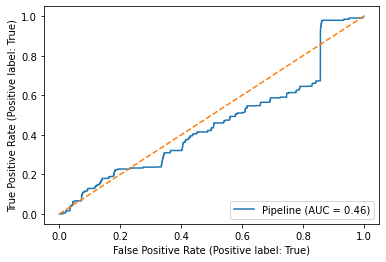

In [12]:
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.plot([0,1], [0,1], '--');

In our particular question, it's most important that we minimize total costs. Here, we check the total costs for each threshold on a 0.1 interval from 0 to 1. It looks like at some point between 0 and 0.1, there's a point where our regression only predicts a False. (That's likely also where our ROC makes a leap.)

In [13]:
threshold_range = np.arange(0, 1.1, 0.1)
costs = {t: cost_scorer(y_test, [p[1] > t for p in fuel_test_probs], cost_fp=500, cost_fn=5000) for t in threshold_range}
costs

{0.0: 58569000,
 0.1: 5595000,
 0.2: 5595000,
 0.30000000000000004: 5595000,
 0.4: 5595000,
 0.5: 5595000,
 0.6000000000000001: 5595000,
 0.7000000000000001: 5595000,
 0.8: 5595000,
 0.9: 5595000,
 1.0: 5595000}

### Let's experiment with looping this basic model for different target window times
We're using the same setup as above; however, now we're building a larger dictionary for a variety of target windows from 3 hours to 5 days

In [14]:
windows = np.concatenate([np.arange(3, 27, 3), np.arange(36, 121, 12)])
costs_dict = {}
for window in windows:
    df = create_target_window(fdwide, both_derate_types=False, target_window_hours=float(window))
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(df, model_cols=['FuelLtd'], trucks = True)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    fuel_test_probs = pipeline.predict_proba(X_test)

    threshold_range = np.arange(0, 1.1, 0.1)
    costs_dict[f"{window} hours"] = {t: cost_scorer(y_test, [p[1] > t for p in fuel_test_probs], cost_fp=500, cost_fn=5000) for t in threshold_range}

Collecting these results into a dataframe, we see that the minimum cost for each window occurs at the 0.1 threshold; however, the 3-hour target introduces the lowest costs.

In [15]:
costs_df = (pd.DataFrame.from_dict(costs_dict, orient='index')
        .reset_index()
        .melt(id_vars='index', 
              var_name='threshold', 
              value_name='cost')
        .rename(columns = {'index': 'target_window'})
    )
(costs_df.sort_values(['cost', 'threshold'])
         .drop_duplicates(subset = ['target_window', 'cost'])
         .reset_index(drop = True)
         .head(10)
)

target_window threshold     cost
0       3 hours       0.1  1265000
1       6 hours       0.1  1560000
2       9 hours       0.1  1690000
3      12 hours       0.1  2875000
4      15 hours       0.1  3200000
5      18 hours       0.1  3365000
6      21 hours       0.1  3485000
7      24 hours       0.1  3585000
8      36 hours       0.1  4055000
9      48 hours       0.1  4235000

### As a last step with this simple model, let's look at all the reporting content with the target window and threshold optimized.
So we're setting the window to 3 and the threshold to 0.1 (though we'll explore this a little, too).

In [16]:
df = create_target_window(fdwide, both_derate_types=False, target_window_hours=3)
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(df, model_cols=['FuelLtd'], trucks = True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
fuel_test_probs = pipeline.predict_proba(X_test)

Confirmed: Our optimal threshold is just the first threshold that never predicts a derate. There's some tension here, then, in whether to prioritize optimizing total costs or the f1 score. Most likely the total costs are the most important. We might just need some more features.

In [17]:
t = 0.1
preds = [p[1] > t for p in fuel_test_probs]
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print("confusion matrix:\n", confusion_matrix(y_test, preds))
print("False Positives: ", fp, "\nFalse Negatives: ", fn)
print("f1 score: ", f1_score(y_test, preds))
print("Total Cost: ",  "${:,.2f}".format(cost_scorer(y_test, preds, cost_fp=500, cost_fn=5000)))

confusion matrix:
 [[118004      0]
 [   253      0]]
False Positives:  0 
False Negatives:  253
f1 score:  0.0
Total Cost:  $1,265,000.00


In [18]:
fpr, tpr, thresholds = roc_curve(y_test, [p[1] for p in fuel_test_probs])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("The optimum tpr vs. fpr threshold value is:", optimal_threshold)

The optimum tpr vs. fpr threshold value is: 0.002433986909513555


In [19]:
fig = px.area(
    x=fpr, 
    y=tpr,
    hover_data=[thresholds],
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', 
                y='True Positive Rate',
                hover_data_0 = 'Threshold'),
    width=700, 
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [20]:
t = optimal_threshold
preds = [p[1] > t for p in fuel_test_probs]
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print("confusion matrix:\n", confusion_matrix(y_test, preds))
print("False Positives: ", fp, "\nFalse Negatives: ", fn)
print("f1 score: ", f1_score(y_test, preds))
print("Total Cost: ",  "${:,.2f}".format(cost_scorer(y_test, preds, cost_fp=500, cost_fn=5000)))

confusion matrix:
 [[107268  10736]
 [   196     57]]
False Positives:  10736 
False Negatives:  196
f1 score:  0.010320478001086365
Total Cost:  $6,348,000.00


## fault and wear model: spn and fmi (fault details) as well as FuelLtd, DistanceLtd, EngineTimeLtd (wear and tear)
- build prototype model with 6-hour window
- find best model when considering windows between 3 hours and 5 days as well as thresholds on different magnitudes

### build prototype model with 6-hour window

In [21]:
df = create_target_window(fdwide, both_derate_types=False, target_window_hours=6)
catcols = ['spn', 'fmi']

X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(df, model_cols=['spn', 'fmi', 'FuelLtd', 'DistanceLtd', 'EngineTimeLtd'], trucks = True)

ct = ColumnTransformer([
            ('ohe', OneHotEncoder(sparse = False, drop = 'first', handle_unknown="ignore"), catcols)
        ],
        remainder="passthrough"
    )

pipeline = Pipeline([
    ('ct', ct),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros



In [25]:
fpr, tpr, thresholds = roc_curve(y_test, [p[1] for p in y_probs])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("The optimum tpr vs. fpr threshold value is:", optimal_threshold)

fig = px.area(
    x=fpr, 
    y=tpr,
    hover_data=[thresholds],
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', 
                y='True Positive Rate',
                hover_data_0 = 'Threshold'),
    width=700, 
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

The optimum tpr vs. fpr threshold value is: 0.0033386129562409574


In [61]:
threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1.1, 0.1)])
costs = {t: {'total costs': cost_scorer(y_test, [p[1] > t for p in y_probs], cost_fp=500, cost_fn=5000), 'f1_score': f1_score(y_test, [p[1] > t for p in y_probs])} for t in threshold_range}

In [65]:
pd.DataFrame.from_dict(costs, orient='index').reset_index().rename(columns = {'index' : 'threshold'}).sort_values('f1_score', ascending = False)

threshold  total costs  f1_score
23      0.600      1091000  0.321343
22      0.500      1091500  0.320574
21      0.400      1092000  0.319809
20      0.300      1084000  0.317673
24      0.700      1105500  0.309927
25      0.800      1110500  0.305825
19      0.200      1083500  0.298279
26      0.900      1164500  0.260652
18      0.100      1145000  0.228710
17      0.090      1156500  0.221963
16      0.080      1155500  0.219565
15      0.070      1168500  0.211462
14      0.060      1195000  0.200743
13      0.050      1274500  0.175250
12      0.040      1451500  0.144467
11      0.030      1573500  0.133278
10      0.020      1819500  0.115496
9       0.010      2378500  0.089330
8       0.009      2568000  0.082972
7       0.008      2818500  0.075851
6       0.007      2998500  0.071935
5       0.006      3145500  0.068455
4       0.005      3286500  0.065620
3       0.004      3526500  0.061409
2       0.003      3945000  0.055103
1       0.002      4534500  0.047977
0       0.001      7771000  0.028787
27      1.000      1390000  0.000000

In [63]:
costs_df = pd.DataFrame.from_dict(costs, orient='index').reset_index().rename(columns = {'index' : 'threshold'})
min_costs = costs_df['total costs'].min()
cheapest_threshold = costs_df.nsmallest(1, 'total costs')['threshold'].values[0]
px.line(costs_df,
    x = 'threshold',
    y = 'total costs',
    width = 700,
    height = 500,
    title=f'Total Costs by Threshold (Min Total Costs: ${min_costs:,.2f}) at Threshold: {cheapest_threshold}'
)

In [69]:
t = cheapest_threshold
preds = [p[1] > t for p in y_probs]
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print("confusion matrix:\n", confusion_matrix(y_test, preds))
print("False Positives: ", fp, "\nFalse Negatives: ", fn)
print("f1 score: ", f1_score(y_test, preds))
print("Total Cost: ",  "${:,.2f}".format(cost_scorer(y_test, preds, cost_fp=500, cost_fn=5000)))

confusion matrix:
 [[116542    167]
 [   200     78]]
False Positives:  167 
False Negatives:  200
f1 score:  0.29827915869980876
Total Cost:  $1,083,500.00


### find best model when considering windows between 3 hours and 5 days as well as thresholds on different magnitudes
- The performing model (on the basis of lowest cost) is the 3-hour window wth a threshold of 0.2

In [71]:
threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1.1, 0.1)])
windows = np.concatenate([np.arange(3, 27, 3), np.arange(36, 121, 12)])
fault_and_wear_dict = {}
for window in windows:
    df = create_target_window(fdwide, both_derate_types=False, target_window_hours=float(window))
    catcols = ['spn', 'fmi']

    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(df, model_cols=['spn', 'fmi', 'FuelLtd', 'DistanceLtd', 'EngineTimeLtd'], trucks = True)

    ct = ColumnTransformer([
                ('ohe', OneHotEncoder(sparse = False, drop = 'first', handle_unknown="ignore"), catcols)
            ],
            remainder="passthrough"
        )

    pipeline = Pipeline([
        ('ct', ct),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_probs = pipeline.predict_proba(X_test)
    fault_and_wear_dict[f"{window} hours"] = {t: {'total costs': cost_scorer(y_test, [p[1] > t for p in y_probs], cost_fp=500, cost_fn=5000), 'f1_score': f1_score(y_test, [p[1] > t for p in y_probs])} for t in threshold_range}

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1] during t

In [77]:
fault_and_wear_df = pd.concat({k: pd.DataFrame(v).T for k, v in fault_and_wear_dict.items()}, axis=0).reset_index().rename(columns = {'level_0':'target_window', 'level_1':'threshold'})
fault_and_wear_df

target_window  threshold  total costs  f1_score
0         3 hours      0.001    6334500.0  0.029099
1         3 hours      0.002    4070500.0  0.043896
2         3 hours      0.003    3543000.0  0.050461
3         3 hours      0.004    3064000.0  0.057942
4         3 hours      0.005    2637000.0  0.067179
..            ...        ...          ...       ...
443     120 hours      0.600    5049500.0  0.116319
444     120 hours      0.700    5049000.0  0.116421
445     120 hours      0.800    5053500.0  0.114883
446     120 hours      0.900    5181500.0  0.071492
447     120 hours      1.000    5380000.0  0.000000

[448 rows x 4 columns]

In [85]:
fault_and_wear_df.sort_values('total costs').head(5)

target_window  threshold  total costs  f1_score
19       3 hours        0.2     795500.0  0.360494
20       3 hours        0.3     800500.0  0.371968
23       3 hours        0.6     806000.0  0.372222
22       3 hours        0.5     806500.0  0.371191
21       3 hours        0.4     807000.0  0.370166

In [86]:
fault_and_wear_df.sort_values('f1_score', ascending = False).head(5)

target_window  threshold  total costs  f1_score
23       3 hours        0.6     806000.0  0.372222
20       3 hours        0.3     800500.0  0.371968
22       3 hours        0.5     806500.0  0.371191
21       3 hours        0.4     807000.0  0.370166
19       3 hours        0.2     795500.0  0.360494

## Appendix

In [22]:
# dropcols = ['RecordID','actionDescription','ESS_Id','eventDescription', 'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake', 'ecuSource', 
#             'faultValue', 'EquipmentID', 'MCTNumber', 'LocationTimeStamp', 'eventGroup', 'FaultId', 'EventTimeStamp', 'ParkingBrake', 'ServiceDistance',
#             'SwitchedBatteryVoltage', 'FuelTemperature', 'Throttle', 'spn-fmi']
# catcols = ['spn', 'fmi', 'LampStatus']
# X = df.assign(timeTillLast = df['timeTillLast'].dt.total_seconds()).drop(columns = dropcols).dropna()
# X.shape

Earlier iteration of train-test-validate and its models

In [23]:
# def train_test_val_split(X, y, trucks = False):

#     X_strat = stratifier(X, trucks)
#     y_strat = stratifier(y, trucks)
#     X_train = X_strat.loc[X_strat['train_test_val']=='train', X_strat.drop(columns = ['EventTimeStamp', 'train_test_val', 'EquipmentID']).columns]
#     y_train = y_strat.loc[y_strat['train_test_val']=='train', 'target']
#     X_test = X_strat.loc[X_strat['train_test_val']=='test', X_strat.drop(columns = ['EventTimeStamp', 'train_test_val', 'EquipmentID']).columns]
#     y_test = y_strat.loc[y_strat['train_test_val']=='test', 'target']
#     X_val = X_strat.loc[X_strat['train_test_val']=='val', X_strat.drop(columns = ['EventTimeStamp', 'train_test_val', 'EquipmentID']).columns]
#     y_val = y_strat.loc[y_strat['train_test_val']=='val', 'target']
    
#     return X_train, y_train, X_test, y_test, X_val, y_val

In [24]:
# df = create_target_window(fdwide, both_derate_types=False, target_window_hours=120)
# df_selected = df[['EventTimeStamp', 'EquipmentID', 'FuelLtd', 'target']].dropna()

# X = df_selected[['EventTimeStamp', 'EquipmentID', 'FuelLtd']]
# y = df_selected[['EventTimeStamp', 'EquipmentID','target']]

# X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y, trucks = True)

# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('logreg', LogisticRegression())
# ])

# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# fuel_test_probs = pipeline.predict_proba(X_test)

# print("f1_score: ", f1_score(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# print(pd.Series(np.split(fuel_test_probs,2,axis=1)[1].flatten()).describe())